### <b> Apple Classifier </b> 

This notebook is a Deep Learning project  to train and deploy an image classifier using FastAI's API.

In [1]:
from fastbook import *
from fastai.vision.widgets import *

##### <b> 1. Gathering Data from the web </b>

In [2]:
apple_types = ['red', 'green', 'logo']
path = Path('apple')

In [ ]:
# Search for and download images
for a in apple_types:
    dest = (path/a)
    results = search_images_ddg(f'{a} apple images')
    for i in range(len(results)):
        try:
            download_url(results[i], dest / f'{i}.jpg')
        except Exception as e:
            print(f"Error downloading {results[i]}: {e}")

In [4]:
#Check download images to designated path
images = get_image_files(path)
images

(#580) [Path('apple/green/0.jpg'),Path('apple/green/1.jpg'),Path('apple/green/10.jpg'),Path('apple/green/100.jpg'),Path('apple/green/101.jpg'),Path('apple/green/102.jpg'),Path('apple/green/103.jpg'),Path('apple/green/104.jpg'),Path('apple/green/105.jpg'),Path('apple/green/106.jpg')...]

In [8]:
# Check for corrupt images
failed = verify_images(images)
failed

(#25) [Path('apple/green/108.jpg'),Path('apple/green/117.jpg'),Path('apple/green/133.jpg'),Path('apple/green/174.jpg'),Path('apple/green/197.jpg'),Path('apple/green/199.jpg'),Path('apple/green/38.jpg'),Path('apple/green/51.jpg'),Path('apple/logo/104.jpg'),Path('apple/logo/11.jpg')...]

In [9]:
#Remove corrupt images from directory
failed.map(Path.unlink)

(#25) [None,None,None,None,None,None,None,None,None,None...]

##### <b> 2. Data Loaders and Data Augmentation </b>

A DataLoader object allows you to store data and <b> split it into training and validation sets </b>.
<p> In this case, I'll use the <b> data block API </b> that is extremely flexible and customizable. </p>

In [10]:
apples = DataBlock(
    blocks=(ImageBlock,CategoryBlock), #defines the Independente and Dependent variables
    get_items=get_image_files, # asserts the types of data that will be used and fetches a list of all images it from a designated file path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), #splits the dataset randomly into training (0.8) and validation (0.2)
    get_y=parent_label, #gets the labels from the name of the parent directory of the images
    item_tfms=Resize(128) #adjusts the images to a size of 128x128
)

In [11]:
#Create the DataLoader based on the previously defined DataBlock and path
dls = apples.dataloaders(path)

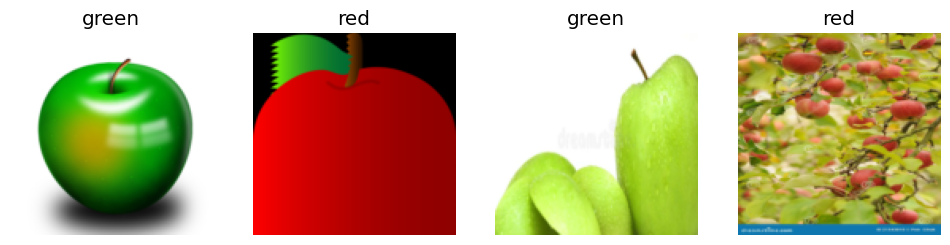

In [17]:
#Check a few items from the validation set
dls.valid.show_batch(max_n=4, nrows=1)

To prevent images from losing details when being resized to 128x128, we can alternatively <b> pad </b> the images or <b> squish/stretch</b> them.
<p> </p> In order to do so we can change the type of item transformation that is applied to the DataBlock:

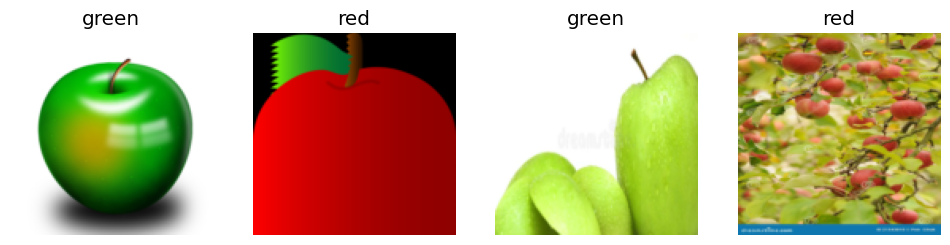

In [16]:
# Squishing transformation
apples = apples.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = apples.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

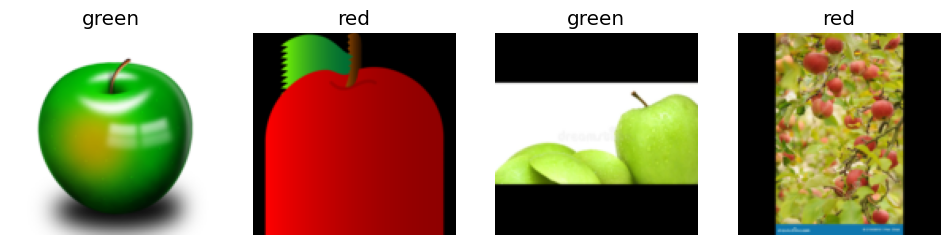

In [15]:
# Padding transformation
apples = apples.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = apples.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

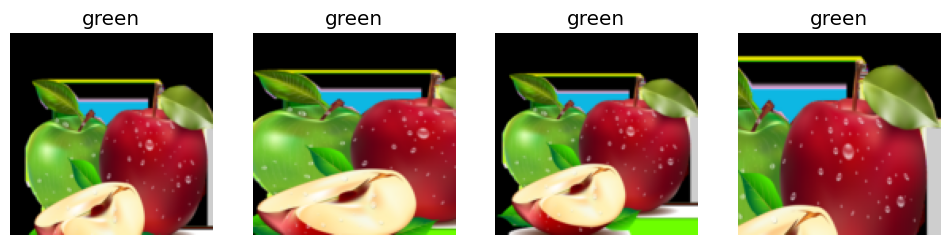

In [19]:
# Cropping the image at a minimum of 0.3 of the original image
apples = apples.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = apples.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True) # Check for several transformation on the same image

The above image is a mix of red and green apples and is classified as green, which isn't good for the model. We'll solve this issue by removing it from the set afer training the model (even though it might be conterintuitive, FastAI's API has a built-in functionality to get rid of "garbage" in the dataset after training).

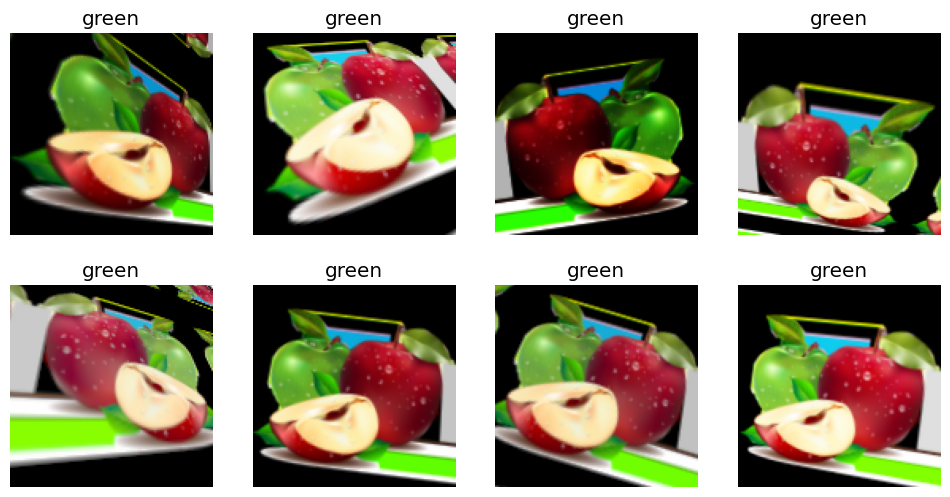

In [20]:
# More data augmentation using the aug-transforms function
apples = apples.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = apples.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

#### <b> 3. Training the Model and Cleaning the Data </b>

##### <b> 3.1.1. Before cleaning the dataset </b>

In [37]:
# Asserting the transformations applied to individual images and the augmentations applied to a batch in our DataLoad
apples = apples.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = apples.dataloaders(path)

Create the <code>Learner</code> and fine-tune it using <code> ResNet18</code>:

In [38]:
learner0 = vision_learner(dls, resnet18, metrics=error_rate)
learner0.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.343502,0.457132,0.180180,00:24


c:\Users\Rodrigo\anaconda3\envs\torchEnv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.473804,0.305551,0.099099,00:24
1,0.382670,0.240960,0.081081,00:25
2,0.343668,0.235382,0.072072,00:25
3,0.285961,0.237375,0.063063,00:24


c:\Users\Rodrigo\anaconda3\envs\torchEnv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


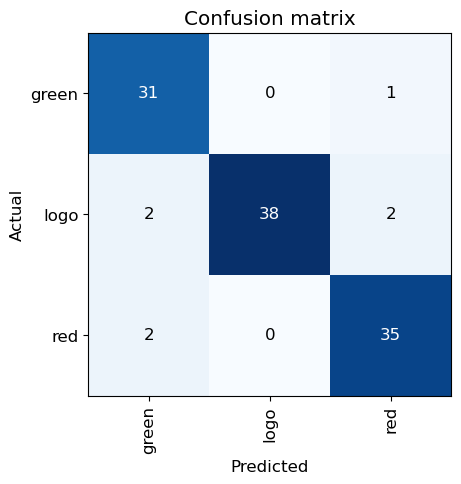

In [40]:
# Plotting confusion matrix to see how well the model is identifying apples
interp = ClassificationInterpretation.from_learner(learner0)
interp.plot_confusion_matrix()

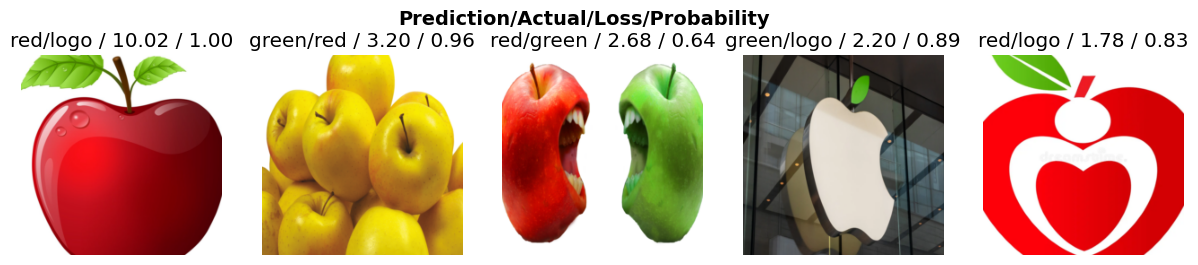

In [41]:
interp.plot_top_losses(5, nrows=1)

In [52]:
cleaner = ImageClassifierCleaner(learner0)
cleaner

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Rodrigo\\Desktop\\AppleClassifier\\apple\\green\\130.jpg'

In [49]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [51]:
learner0 = vision_learner(dls, resnet18, metrics=error_rate)
learner0.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time


c:\Users\Rodrigo\anaconda3\envs\torchEnv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Rodrigo\\Desktop\\AppleClassifier\\apple\\red\\197.jpg'

##### <b> 3.1.2. After cleaning the dataset </b>

In [54]:
dls = apples.dataloaders(path)

In [55]:
learner0 = vision_learner(dls, resnet18, metrics=error_rate)
learner0.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.167048,0.279054,0.086538,00:22


c:\Users\Rodrigo\anaconda3\envs\torchEnv\Lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.326923,0.105106,0.028846,00:22
1,0.250730,0.058316,0.019231,00:23
2,0.197063,0.063526,0.019231,00:22
3,0.160330,0.063279,0.028846,00:22


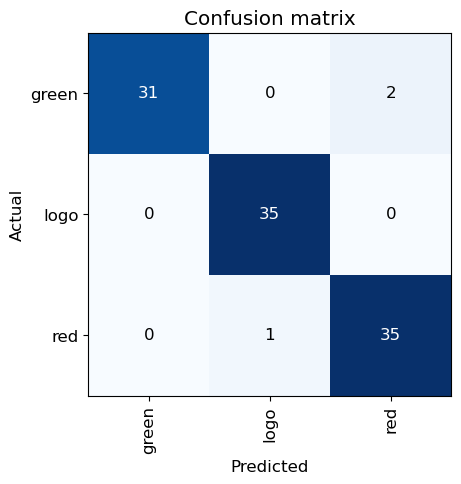

In [56]:
interp = ClassificationInterpretation.from_learner(learner0)
interp.plot_confusion_matrix()

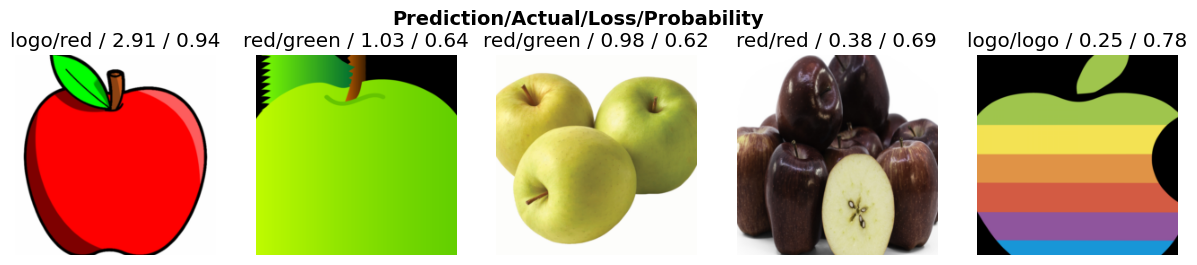

In [57]:
interp.plot_top_losses(5, nrows=1)